# Word Embedings & Clustering in clinical trials
In below notebook I used Word Embeding techniques on clinical trials data

### Data preparation

In [ ]:
import pandas as pd

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df_selected_columns = pd.read_csv('df_selected_columns.csv')

In [ ]:
df_selected_columns.head()

,Unnamed: 0,hasResults,identificationModule.nctId,identificationModule.organization.fullName,identificationModule.organization.class,identificationModule.briefTitle,identificationModule.officialTitle,statusModule.statusVerifiedDate,statusModule.studyFirstSubmitDate,statusModule.studyFirstPostDateStruct.type,statusModule.lastUpdatePostDateStruct.date,sponsorCollaboratorsModule.responsibleParty.type,sponsorCollaboratorsModule.leadSponsor.name,sponsorCollaboratorsModule.leadSponsor.class,descriptionModule.briefSummary,descriptionModule.detailedDescription,designModule.studyType,designModule.enrollmentInfo.count,designModule.enrollmentInfo.type,eligibilityModule.eligibilityCriteria,eligibilityModule.sex,eligibilityModule.minimumAge,armsInterventionsModule.armGroups_0_label,armsInterventionsModule.armGroups_0_description,armsInterventionsModule.armGroups_0_type,armsInterventionsModule.armGroups_1_label,armsInterventionsModule.armGroups_1_description,armsInterventionsModule.armGroups_1_type,armsInterventionsModule.interventions_0_type,armsInterventionsModule.interventions_0_name,armsInterventionsModule.interventions_0_description,outcomesModule.primaryOutcomes_0_measure,outcomesModule.primaryOutcomes_0_description,outcomesModule.primaryOutcomes_0_timeFrame,outcomesModule.secondaryOutcomes_0_measure,outcomesModule.secondaryOutcomes_0_description,outcomesModule.secondaryOutcomes_0_timeFrame,contactsLocationsModule.overallOfficials_0_name,contactsLocationsModule.overallOfficials_0_affiliation,contactsLocationsModule.overallOfficials_0_role,contactsLocationsModule.locations_0_facility,contactsLocationsModule.locations_0_city,contactsLocationsModule.locations_0_country,conditionBrowseModule.meshes_0_term,conditionBrowseModule.ancestors_0_term,conditionBrowseModule.ancestors_1_term,conditionBrowseModule.ancestors_2_term,conditionBrowseModule.browseLeaves_0_name,conditionBrowseModule.browseLeaves_1_name,conditionBrowseModule.browseLeaves_2_name,conditionBrowseModule.browseLeaves_3_name,conditionBrowseModule.browseLeaves_4_name,conditionBrowseModule.browseBranches_0_name,conditionBrowseModule.browseBranches_2_name
0,0,False,nct06733961,giresun university,NaN,scube 1 vap 1 levels diagnosis pulmonary embolism,investigation relationship scube 1 vap 1 level...,2024 11,2024 12 01,estimated,2024 12 13,principal_investigator,giresun university,NaN,acute pulmonary thromboembolism life threateni...,definitive diagnosis apt made ventilation perf...,observational,88,actual,inclusion criteria older 18 years age presenti...,NaN,18 years,patient group,consists patients diagnosed pulmonary thromboe...,NaN,control group,composed healthy volunteers similar age gender...,NaN,diagnostic_test,scube 1 vap 1,study comparing biomarkers healthy volunteers ...,diagnostic ability scube 1 vap 1 pulmonary emb...,serum scube 1 serum vap 1 levels patient contr...,6 month,difference clinical probability scores serum s...,clinical probability scores patient group grou...,6 month,hizir u akdemir prof,ondokuz mayıs university,study_chair,ondokuz mayis university,samsun,turkey,pulmonary embolism,embolism thrombosis,vascular diseases,cardiovascular diseases,pulmonary embolism,embolism,thromboembolism,emergencies,thrombosis,respiratory tract lung bronchial diseases,conditions
1,1,False,nct06733857,game changers institute,NaN,environmental costs building human muscle,environmental costs building human muscle comp...,2024 12,2024 12 04,estimated,2024 12 13,sponsor,game changers institute,NaN,among general population established plant bas...,development skeletal muscle mass associated im...,interventional,22,actual,inclusion criteria males females 18 40 years a...,NaN,18 years,plant based,participants consume high protein plant based ...,experimental,omnivorous,participants consume high protein omnivorous d...,active_comparator,behavioral,veg2,participants provided caloric target place 0 1...,diet related greenhouse gas emissions co2 equi...,diet related greenhouse gas emissions 

## Word  Embedding



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


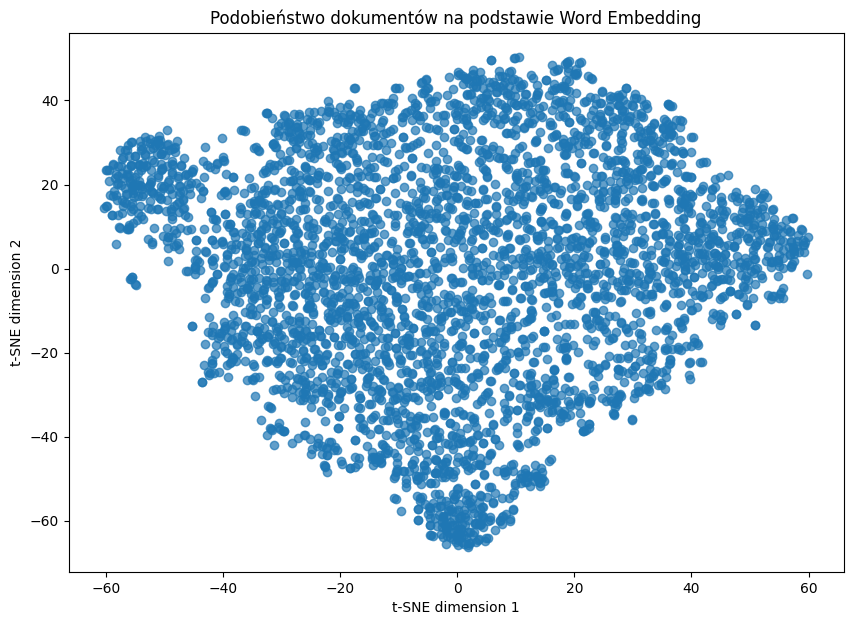

In [ ]:
import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Downloading necessary data for NLTK
nltk.download('punkt')
nltk.download('punkt_tab')

# Assuming `df_selected_columns` is your DataFrame with text columns
# Selecting text columns and tokenizing the data within them
text_columns = df_selected_columns.select_dtypes(include=['object']).columns
df_selected_columns['tokens'] = df_selected_columns[text_columns].apply(
    lambda row: [word for col in row for word in word_tokenize(str(col).lower()) if pd.notnull(col)],
    axis=1
)

# Training the Word2Vec model on the collected tokens
model = Word2Vec(sentences=df_selected_columns['tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Calculating average vectors for each document
def document_vector(tokens, model):
    # Using the average vector for words in the document
    return np.mean([model.wv[word] for word in tokens if word in model.wv], axis=0)

df_selected_columns['vector_avg'] = df_selected_columns['tokens'].apply(lambda tokens: document_vector(tokens, model))

# Removing rows without vectors (in case some documents have an empty word list)
df_vectors = df_selected_columns.dropna(subset=['vector_avg'])

# Creating a matrix of vectors
doc_vectors = np.vstack(df_vectors['vector_avg'].values)

# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(doc_vectors)

# Visualizing the documents
plt.figure(figsize=(10, 7))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.7)
plt.title('Podobieństwo dokumentów na podstawie Word Embedding')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

## Word Emebeding with Clustering
Let's try the same method, but with adding clustering to find groups of highest similarity.  


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


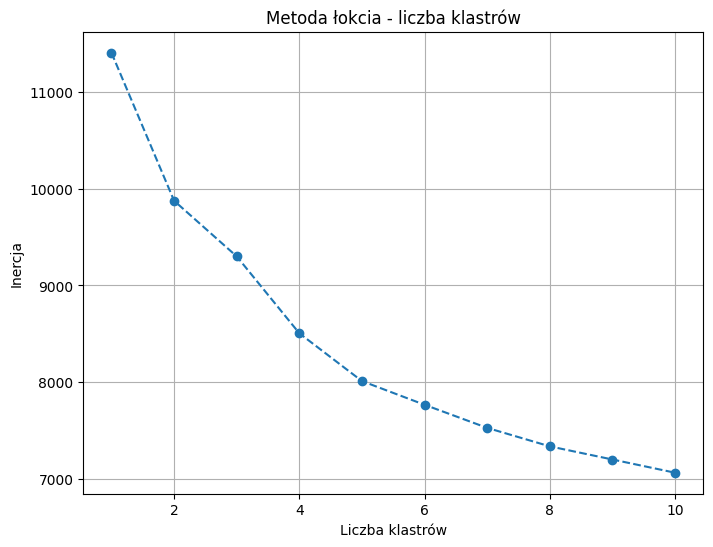

In [ ]:
import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns  # Importing seaborn for scatterplot with hue

# Downloading necessary data for NLTK
nltk.download('punkt')

# Assuming `df_selected_columns` is your DataFrame with text columns
# Selecting text columns and tokenizing the data within them
text_columns = df_selected_columns.select_dtypes(include=['object']).columns
df_selected_columns['tokens'] = df_selected_columns[text_columns].apply(
    lambda row: [word for col in row
                # Convert cell value to string before tokenization
                for word in word_tokenize(str(col).lower())
                # Check if the original *cell value* (col) is not null.
                # Check if the cell value is not an array-like and then if it's not null
                if not isinstance(col, (list, np.ndarray)) and pd.notnull(col)],
    axis=1
)

# Training the Word2Vec model on the collected tokens
model = Word2Vec(sentences=df_selected_columns['tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Calculating average vectors for each document
def document_vector(tokens, model):
    # Using the average vector for words in the document
    return np.mean([model.wv[word] for word in tokens if word in model.wv], axis=0)

df_selected_columns['vector_avg'] = df_selected_columns['tokens'].apply(lambda tokens: document_vector(tokens, model))

# Removing rows without vectors (in case some documents have an empty word list)
df_vectors = df_selected_columns.dropna(subset=['vector_avg'])

# Creating a matrix of vectors
doc_vectors = np.vstack(df_vectors['vector_avg'].values)

# Calculating the number of clusters using the elbow method
inertia = []  # List to store the results
K_range = range(1, 11)  # Checking clustering for 1 to 10 clusters
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(doc_vectors)
    inertia.append(kmeans.inertia_)

# Visualizing the elbow method
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method - Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()



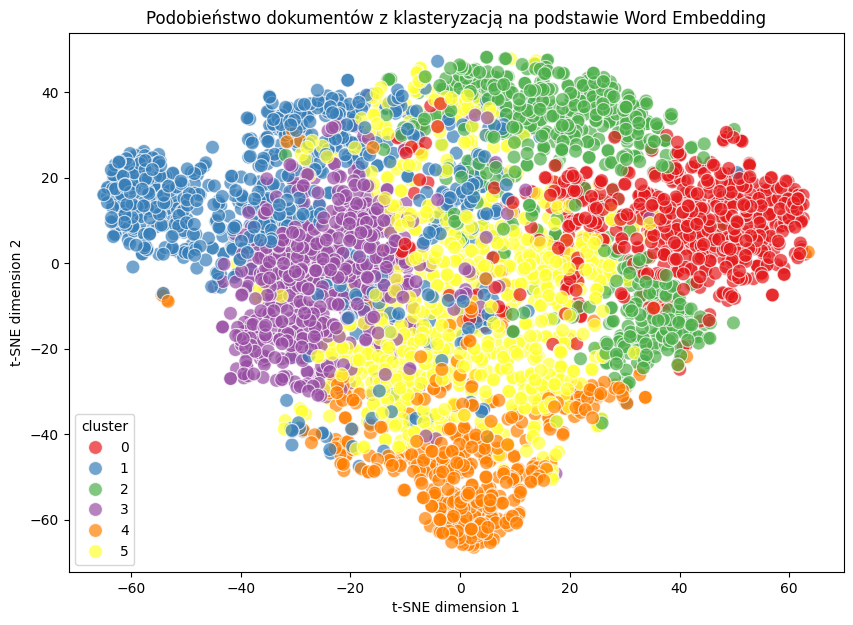

In [ ]:
# Selecting the optimal k (based on the elbow method plot)
optimal_k = 6  # For example, we choose 6 based on the plot

# Clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_vectors['cluster'] = kmeans.fit_predict(doc_vectors)

# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(doc_vectors)

# Visualization of documents with clustering
plt.figure(figsize=(10, 7))
sns.scatterplot(x=reduced_vectors[:, 0], y=reduced_vectors[:, 1], hue=df_vectors['cluster'], palette='Set1', s=100, alpha=0.7)
plt.title('Document Similarity with Clustering Based on Word Embedding')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()


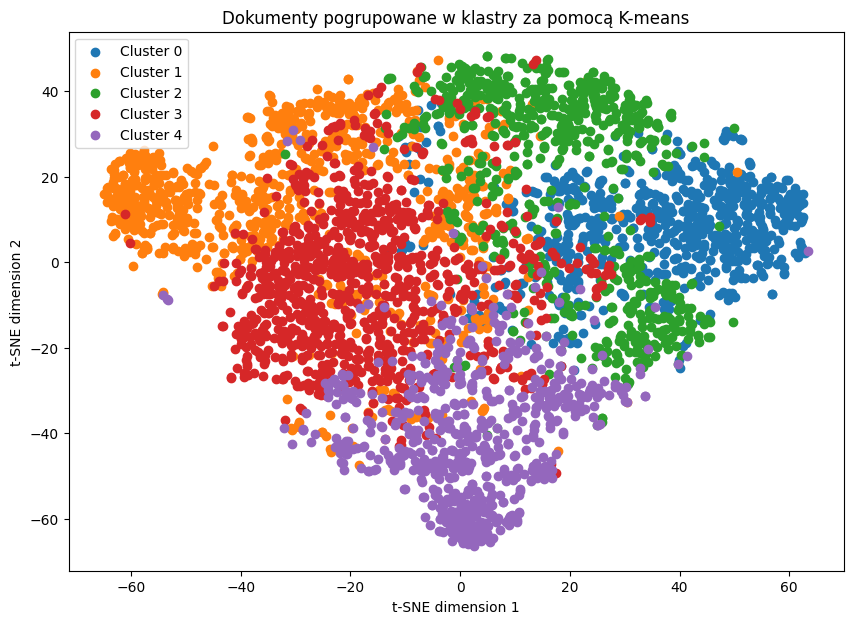

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

# Converting the 'vector_avg' column to a matrix (list of document vectors)
doc_vectors = np.vstack(df_selected_columns['vector_avg'].dropna().values)

# Defining the number of clusters. You can start with an arbitrary value, e.g., 5.
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(doc_vectors)

# Adding cluster labels to the DataFrame
df_selected_columns.loc[df_selected_columns['vector_avg'].notna(), 'cluster'] = kmeans.labels_

# Exporting clusters to separate DataFrames
cluster_dfs = []
for i in range(n_clusters):
    cluster_df = df_selected_columns[df_selected_columns['cluster'] == i]
    cluster_dfs.append(cluster_df)
    # Optionally export to CSV
    cluster_df.to_csv(f'cluster_{i}.csv', index=False)

# Visualizing clusters with t-SNE
# Dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(doc_vectors)

# Plotting the chart with colors corresponding to clusters
plt.figure(figsize=(10, 7))
for i in range(n_clusters):
    cluster_points = reduced_vectors[kmeans.labels_ == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

plt.title('Documents Grouped into Clusters Using K-means')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend()
plt.show()



## Cosine similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculating the average vector for each cluster
cluster_centers = []
for cluster in range(n_clusters):
    cluster_vectors = np.vstack(df_selected_columns[df_selected_columns['cluster'] == cluster]['vector_avg'].dropna())
    cluster_centers.append(cluster_vectors.mean(axis=0))

# Calculating the cosine similarity matrix between clusters
similarity_matrix = cosine_similarity(cluster_centers)

# Displaying the similarity matrix
print("Cosine Similarity between cluster centers:")
print(similarity_matrix)

Cosine Similarity between cluster centers:
[[1.0000001  0.8807503  0.94003224 0.90070856 0.880125  ]
 [0.8807503  0.9999999  0.93317765 0.9441727  0.92574716]
 [0.94003224 0.93317765 0.99999976 0.90720016 0.9020582 ]
 [0.90070856 0.9441727  0.90720016 1.0000001  0.9216909 ]
 [0.880125   0.92574716 0.9020582  0.9216909  1.        ]]


*  Cluster 0 & Cluster 2: Similarity = 0.94003224
This indicates high similarity between clusters 0 and 2.

*  Cluster 0 & Cluster 4: Similarity = 0.880125
This is still a strong similarity, though slightly less than with Cluster 2.

*  Cluster 1 & Cluster 3: Similarity = 0.9441727
Again, very similar clusters.

## Word Clouds for identified clusters

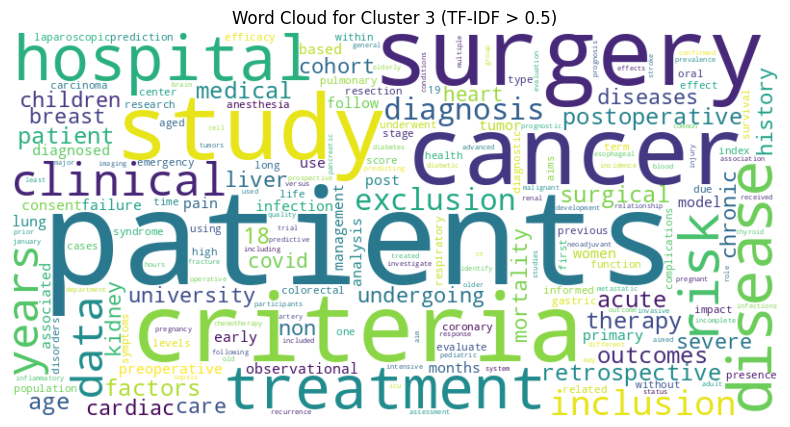

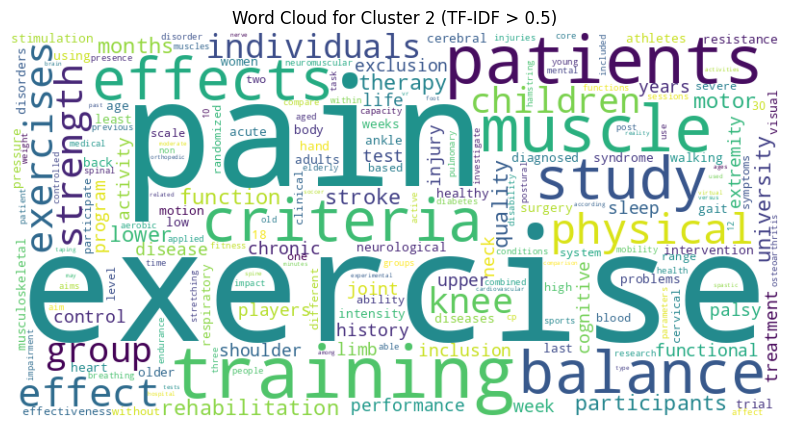

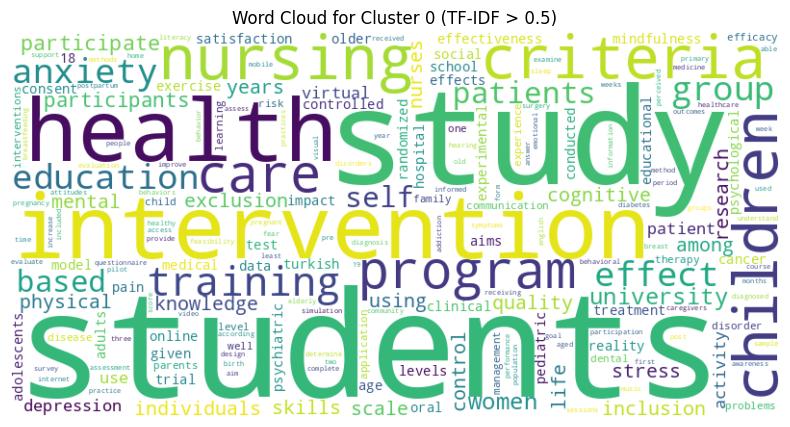

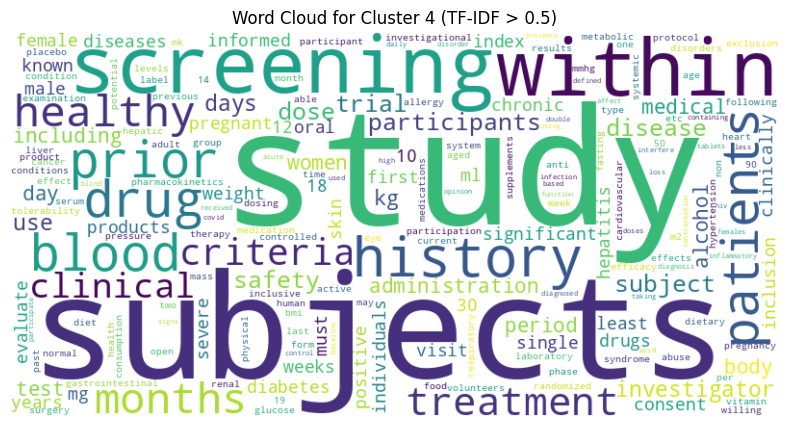

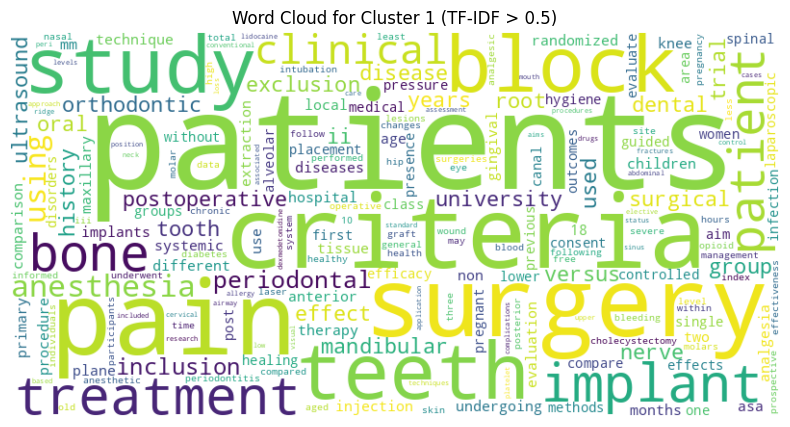

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming you have a DataFrame `df_selected_columns`
# Selecting relevant columns
selected_columns = [
    "identificationModule.organization.fullName",
    "identificationModule.briefTitle",
    "identificationModule.officialTitle",
    "descriptionModule.briefSummary",
    "eligibilityModule.eligibilityCriteria",
]

# Creating text for the entire DataFrame
combined_texts = df_selected_columns[selected_columns].apply(
    lambda row: " ".join(row.dropna().astype(str)), axis=1
)

# Applying TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(combined_texts)
feature_names = vectorizer.get_feature_names_out()

# Converting the resulting matrix into a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Iterating through unique clusters
for cluster in df_selected_columns['cluster'].unique():
    # Filtering rows for the current cluster
    cluster_indices = df_selected_columns['cluster'] == cluster
    cluster_tfidf = tfidf_df[cluster_indices]

    # Summing TF-IDF values for the cluster
    cluster_tfidf_sum = cluster_tfidf.sum(axis=0)

    # Filtering words with TF-IDF value > 0.5
    filtered_tfidf_scores = cluster_tfidf_sum[cluster_tfidf_sum > 0.5].to_dict()

    # Checking if there are words available for generating the word cloud
    if filtered_tfidf_scores:
        # Generating a Word Cloud based on filtered TF-IDF values
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(filtered_tfidf_scores)

        # Displaying the Word Cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for Cluster {int(cluster)} (TF-IDF > 0.5)")
        plt.show()
    else:
        print(f"No words with TF-IDF > 0.5 for Cluster {int(cluster)}")



## Summary
Based on above WordClouds (which were prepared with using TF-IDF where TF-IDF for every cluster is higher than 0.5) we can notice some main characterstic words in eac cluster. For example in WordCloud for Clouster 1 we see words like tooth, teeth, bone, implant, periodontal.  

In overall all clusters are quite similar, further analysis would be needed to get some more specific insights.  
